In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# data input
data = pd.read_csv("../../data/cal_habs_filled_chl_sst_rrs_all_stations.csv")
# summing the two Pseudo-nitzschia species
data["Pn_total"] = data["Pn_delicatissima"].add(data["Pn_seriata"], fill_value=0)
data[["Pn_delicatissima", "Pn_seriata", "Pn_total"]]
#print(data["Pn_total"].to_list())

,Pn_delicatissima,Pn_seriata,Pn_total
0,NaN,1600.000,1600.0000
1,28080.0000,35320.000,63400.0000
2,1599.2302,9595.381,11194.6112
3,1252.0000,0.000,1252.0000
4,6358.0000,1122.000,7480.0000
...,...,...,...
649,1496.0000,0.000,1496.0000
650,NaN,NaN,NaN
651,NaN,NaN,NaN
652,38381.5230,2132.307,40513.8300


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Column names of the Rrs bands to combine
rrs_cols = [c for c in data.columns
            if c.startswith("Rrs_") and c[-1].isdigit()]
rrs_cols

# Sorry nothing except plain wavelengths in code below
#ENV_VARS = ["sst"] # , "chlor_a"
#ENV_VARS = ["Temp", "Avg_Chloro"]

data2 = data[data["Pn_total"].notna()].copy() #Create copy of data by keeping only rows of data where Np_total has a value (non-NA).

# Create a new column in df for the ratio
Rrs_ratio = f"ndi_{wavelength1}_{wavelength2}"
data2[Rrs_ratio] = (data2[wavelength1] - data2[wavelength2]) / (data2[wavelength1] + data2[wavelength2])

In [49]:
predictors = [
    # Blue (chlorophyll absorption)
    "Rrs_440.0",
    "Rrs_445.0",
    "Rrs_470.0",
    "Rrs_490.0",

    # Blue–green transition
    "Rrs_510.0",
    "Rrs_530.0",

    # Green (biomass / reference)
    "Rrs_545.0",
    "Rrs_555.0",

    # Yellow–red
    "Rrs_615.0",
    "Rrs_630.0",

    # Red chlorophyll absorption
    "Rrs_665.0",
    "Rrs_678.0",

    # Red edge / fluorescence
    "Rrs_701.0",
    "Rrs_703.0",
    "Rrs_709.0",
]

In [50]:

# Set up X and y
X = data2[predictors]
#y = data2["pDA"]
y = np.log10(data2["Pn_total"])

# Get rid of NaNs, BRT gets mad otherwise (Keep only the rows where every column in X is non-NA and non-Inf, and apply the exact same row filtering to y.)
mask = np.isfinite(X.to_numpy()).all(axis=1) & np.isfinite(y)

X = X.loc[mask].copy()
y = y.loc[mask].copy()

print(f"Predictors used: {predictors}")
print(f"Number of samples: {len(y)}")

Predictors used: ['Rrs_440.0', 'Rrs_445.0', 'Rrs_470.0', 'Rrs_490.0', 'Rrs_510.0', 'Rrs_530.0', 'Rrs_545.0', 'Rrs_555.0', 'Rrs_615.0', 'Rrs_630.0', 'Rrs_665.0', 'Rrs_678.0', 'Rrs_701.0', 'Rrs_703.0', 'Rrs_709.0']
Number of samples: 406


/srv/conda/envs/notebook/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Boosted Regression Tree setup

First, we’ll split the dataset into training and testing subsets using train_test_split. Here, test_size=0.2 means that 20% of the data are held out for testing, while the remaining 80% are used to train the model. The random_state=42 just fixes the random seed so the split is reproducible; using 42 is arbitrary (the answer to the universe and everything), but it ensures we get the same results every time we run the code. Remove random_state if you want the results to change with every run.



In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

Next, we’ll set up a boosted regression tree using GradientBoostingRegressor. This model builds an ensemble of many shallow decision trees (n_estimators=800, max_depth=3), added sequentially so that each new tree focuses on correcting errors made by the previous ones. The small learning_rate=0.01 slows the learning process to improve generalization, while subsample=0.8 introduces randomness by training each tree on 80% of the data, which helps reduce overfitting. We again set random_state=42 to keep the model behavior reproducible.

In [52]:
brt1 = GradientBoostingRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, subsample=0.8, random_state=18) # change random_state for a new random train set
brt1.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.01
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",800
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.8
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

## Classic overfitting

The model fits the training data well but shows little skill on held-out data, indicating overfitting and limited generalizable signal in the predictors. This likely reflects a combination of model flexibility, high predictor dimensionality, and the indirect relationship between Rrs and Pseudo-nitzschia abundance.

In [64]:
y_pred = brt1.predict(X_test) #predictions of held out data
r = np.corrcoef(y_test, y_pred)[0, 1]
r2 = r2_score(y_test, y_pred)
print(f"BRT Pearson r : {r:.3f}")
print(f"BRT R²        : {r2:.3f}")

BRT Pearson r : 0.363
BRT R²        : 0.061


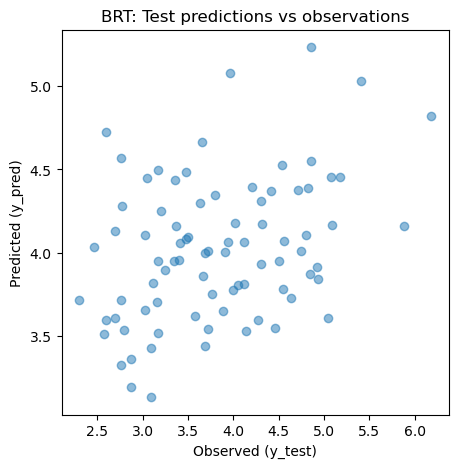

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Observed (y_test)")
plt.ylabel("Predicted (y_pred)")
plt.title("BRT: Test predictions vs observations")
plt.show()

In [66]:
# See how well it fits the training data
y_pred = brt1.predict(X_train) #predictions

r = np.corrcoef(y_train, y_pred)[0, 1]
r2 = r2_score(y_train, y_pred)

print(f"BRT Pearson r : {r:.3f}")
print(f"BRT R²        : {r2:.3f}")

BRT Pearson r : 0.906
BRT R²        : 0.749


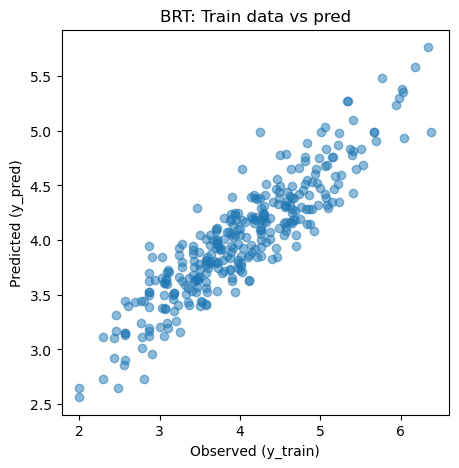

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_pred, alpha=0.5)
plt.xlabel("Observed (y_train)")
plt.ylabel("Predicted (y_pred)")
plt.title("BRT: Train data vs pred")
plt.show()

## Make prediction map

Get some PACE data and make a prediction using Rrs (and only Rrs).

In [68]:
# Function 1 takes a xarray dataset from PACE with Rrs and makes into data frame
import xarray as xr
def make_prediction(R: xr.Dataset, brt_model, feature_cols):
    # --- 3. Stack lat/lon into a single "pixel" dimension ---
    R2 = R.stack(pixel=("lat", "lon"))  # (pixel, wavelength)
    R2 = R2.transpose("pixel", "wavelength")
    # Load this subset into memory
    R2_vals = R2.values  # shape: (n_pixel, n_wavelength)

    # --- 4. Make predictions dataframe
    df_pred = pd.DataFrame(R2_vals, columns=feature_cols)

    # --- 5. Handle NaNs: BRTs generally cannot handle NaNs in predictors ---
    # Rrs dataset will have loads of NaNs
    valid_mask = ~df_pred.isna().any(axis=1)  # pixels with all bands present
    df_valid = df_pred[valid_mask]

    # Prepare an array for predictions (fill NaNs where we cannot predict)
    y_pred_flat = np.full(df_pred.shape[0], np.nan, dtype=float)

    # --- 6. Predict on the valid pixels ---
    if len(df_valid) > 0:
        y_pred_flat[valid_mask.values] = brt_model.predict(df_valid)

    # --- 7. Reshape back to (lat, lon) ---
    nlat = R.sizes["lat"]
    nlon = R.sizes["lon"]
    pred_map = y_pred_flat.reshape(nlat, nlon)

    pred_da = xr.DataArray(
        pred_map,
        coords={"lat": R["lat"], "lon": R["lon"]},
        dims=("lat", "lon"),
        name="y_pred"
    )

    return pred_da

In [69]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def make_brt_plot(
    brt_da: xr.DataArray,
    label: str = "BRT prediction",
    cmap: str = "viridis",
):
    """Plot a single-panel BRT prediction map (lat/lon grid)."""

    # limits from prediction only
    vals = brt_da.values.ravel()
    vmin, vmax = np.nanpercentile(vals, (0, 100))

    fig, ax = plt.subplots(
        1, 1,
        figsize=(6, 4),
        subplot_kw={"projection": ccrs.PlateCarree()},
        constrained_layout=True,
    )

    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="0.9")

    im = ax.pcolormesh(
        brt_da["lon"],
        brt_da["lat"],
        brt_da,
        transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax,
        cmap=cmap,
    )

    ax.set_title(label)
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal", fraction=0.06, pad=0.08)
    cbar.set_label(label)

    plt.show()


### Get the PACE map

In [71]:
import earthaccess
import xarray as xr

day = "2024-07-08"

auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

# Get Rrs
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    temporal = (day, day),
    granule_name="*.DAY.*.4km.nc"
)
f = earthaccess.open(rrs_results[0:1], pqdm_kwargs={"disable": True})
rrs_ds = xr.open_dataset(f[0])

# Get chla
chl_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_CHL",
    temporal = (day, day),
    granule_name="*.DAY.*.4km.nc"
)
f = earthaccess.open(chl_results[0:1], pqdm_kwargs={"disable": True})
chl_ds = xr.open_dataset(f[0])
chl_ds["log10_chla"] = np.log10(chl_ds["chlor_a"])

In [72]:
# Northwest Atlantic
# Set a box
lat_min, lat_max = 30, 60
lon_min, lon_max = -60, -40
# Get Rrs for that box
R = rrs_ds["Rrs"].sel(
    lat=slice(lat_max, lat_min),   # decreasing lat coord: max→min
    lon=slice(lon_min, lon_max)
)
R = R.transpose("lat", "lon", "wavelength")
# Get only the wavelengths in X_train
wavelengths = np.array([float(c.split("_")[1]) for c in X_train.columns])
R_sel = R.sel(wavelength=wavelengths)

# Get CHLA for that box
chla = chl_ds["log10_chla"].sel(
    lat=slice(lat_max, lat_min),   # decreasing lat coord: max→min
    lon=slice(lon_min, lon_max)
)
chla = chla.transpose("lat", "lon")

In [73]:
%%time
# Make prediction
feature_cols = list(X_train.columns)
pred_da = make_prediction(R_sel, brt1, predictors)

CPU times: user 4.02 s, sys: 201 ms, total: 4.22 s
Wall time: 7.41 s


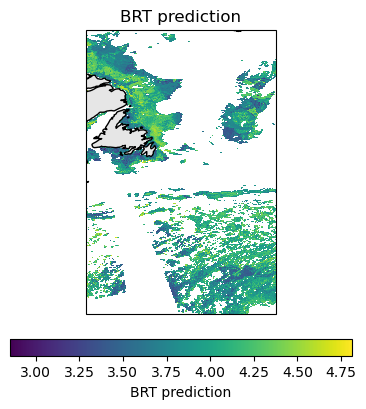

In [74]:
# Make a plot
make_brt_plot(pred_da)